In [1]:
# preparing the dataset before training a ML model
# dataset source: https://data.mendeley.com/datasets/rscbjbr9sj/2
# the dataset contains two categories: Normal and Pneumonia
# in the case of Pneumania, the origin can be Virus or Bacteria
# in this study, we analyse the balancing of the data and we preprare 
# the images with the pipeline_1 (see: Chest_X_Ray_analysis.ipynt)

In [4]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import cv2 
import matplotlib.pyplot as plt
from rich.progress import Progress

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# defining path of the dataset
source_path = "/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray/"
destination_path = "/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray_preprocess/train/"
source_train = source_path + "train/"
source_test = source_path + "test/"
raw_categories = ["PNEUMONIA", "NORMAL"]
# defining the final dimension of each image in grayscale
final_h = 224
final_w = 224

In [7]:
# we want to split Pneumonia in Virus and Bacteria
list_paths = {}
list_path_pneumonia_train =  glob.glob(source_train + raw_categories[0] + "/*", recursive = True)

In [8]:
# some paths from Pneumonia 
for i in range(4):
    print(list_path_pneumonia_train[i])

/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray/train/PNEUMONIA/person848_bacteria_2769.jpeg
/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray/train/PNEUMONIA/person919_bacteria_2844.jpeg
/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray/train/PNEUMONIA/person1601_bacteria_4212.jpeg
/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg


In [9]:
paths = []
labels = []
dataset = []  # train or test
for source, ds in zip([source_train, source_test], ["train", "test"]):
    for cat in raw_categories:
        tmp_paths = glob.glob(source + cat + "/*", recursive = True)
        if cat == "PNEUMONIA":
            for p in tmp_paths:
                lab = p.split('/')[-1].split('_')[1]
                paths += [p]
                labels += [lab]
                dataset += [ds]
        else:
            paths += tmp_paths
            labels += ['normal'] * len(tmp_paths)
            dataset += [ds] * len(tmp_paths)
df = pd.DataFrame()
df['path'] = paths
df['label'] = labels
df['dataset'] = dataset

In [10]:
print(df.head(-5))

                                                   path     label dataset
0     /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...  bacteria   train
1     /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...  bacteria   train
2     /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...  bacteria   train
3     /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...     virus   train
4     /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...  bacteria   train
...                                                 ...       ...     ...
5846  /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...    normal    test
5847  /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...    normal    test
5848  /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...    normal    test
5849  /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...    normal    test
5850  /content/gdrive/MyDrive/ML-datasets/Chest_X_Ra...    normal    test

[5851 rows x 3 columns]


In [11]:
# counting to check balancing
# train
df_train = df[df['dataset']=='train']
count_train = df_train['label'].value_counts()
count_train.head()

bacteria    2538
normal      1349
virus       1345
Name: label, dtype: int64

In [12]:
# in percentage
count_train = df_train['label'].value_counts(normalize=True)
count_train.head()

bacteria    0.485092
normal      0.257836
virus       0.257072
Name: label, dtype: float64

In [13]:
# test
df_test = df[df['dataset']=='test']
df_test['label'].value_counts()

bacteria    242
normal      234
virus       148
Name: label, dtype: int64

In [14]:
# pipeline_1 : transformation and normalization of images
# see: Chest_X_Ray_analysis.ipynb
def pipeline_1(img, h=250, w=250):
    #resizing the image
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_filter = img
    img_filter = cv2.equalizeHist(img_filter) 
    
    alpha = 2.0  # contrast
    beta = 0.0  # brightness
    img_filter = cv2.convertScaleAbs(img_filter, alpha=alpha, beta=beta)
    img_filter = np.where(img_filter>200, 1, 0)
    
    # cleaning the image
    k = 5
    kernel = np.ones((k, k), np.uint8) 
    img_filter = img_filter.astype('uint8')
    img_filter= cv2.erode(img_filter, kernel, iterations=6)

    # detecting the final area
    cnt = cv2.findNonZero(img_filter)
    x,y,ws,hs = cv2.boundingRect(cnt)
    img = img[y:(y+hs), x:(x+ws)]
    
    # improving
    img = cv2.equalizeHist(img)
    alpha = 1.0  # contrast
    beta = 0.0  # brightness
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    
    # reshape
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
    return img

In [15]:
# transforming and saving the image
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

# create destination folder if it does not exist 
create_folder(destination_path)
# we will merge the train and test datasets and we will create three categories:
# normal, bacteria and virus
# create three subfolders if they do not exist
for sub_f in ["normal", "bacteria", "virus"]:
    create_folder(destination_path + sub_f)

# open each image, apply transformations and normalization and save it 
# in the correct sub folder
with Progress() as progress:
    task = progress.add_task("Processed images...", total=len(df.index))
    for index, row in df.iterrows():
        img_path = row['path']
        label = row['label']
        # name of image
        name = img_path.split('/')[-1]
        # open the image and convert into numpy array
        img = np.array(Image.open(img_path))
        # application of transformations... and rescale
        imgT = pipeline_1(img, h=final_h, w=final_w)
        # convert into pil image...
        imgT = Image.fromarray(imgT.astype('uint8'))
        # .. and save it in the right place
        imgT.save(destination_path + label + '/' + name)
        progress.update(task, advance=1.0)

Output()

In [16]:
# control
# initial number of images
count_0 = df_train['label'].value_counts()
count_1 = df_test['label'].value_counts()
labels = ["normal", "bacteria", "virus"]
counts = {}
for lab in labels:
    counts[lab] = 0
    for co in [count_0, count_1]:
        counts[lab] += co.loc[lab]
print(counts)

{'normal': 1583, 'bacteria': 2780, 'virus': 1493}


In [17]:
# control 
# check how many pictures are in each sub_folder 
samples = []
for sub_f, nb in zip(labels, [counts[lab] for lab in labels]):
    list_img = glob.glob(destination_path + sub_f +'/*')
    samples += [np.random.choice(list_img, size=5, replace=False)]
    print('Number of images in sub-folder {}: {} (initial {})'.format(sub_f, len(list_img), nb))
samples = np.concatenate(samples, axis=0)

Number of images in sub-folder normal: 1583 (initial 1583)
Number of images in sub-folder bacteria: 2780 (initial 2780)
Number of images in sub-folder virus: 1493 (initial 1493)


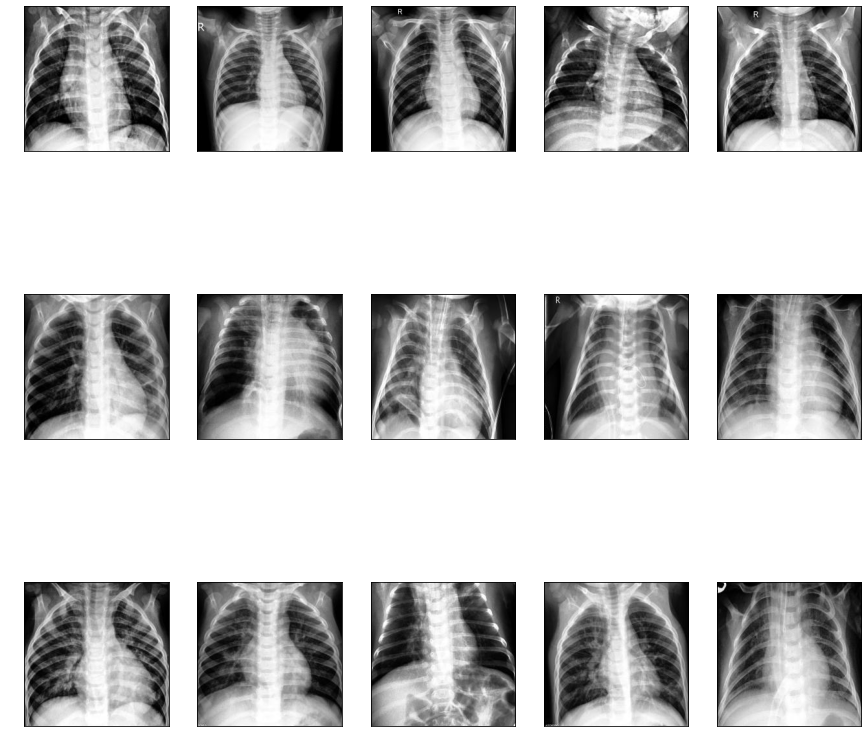

In [19]:
# sampling to control the pipeline execution
plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(3, 5)
for i in range(15):
    img = np.array(Image.open(samples[i]))
    axi = axs[i//5, i%5]
    axi.imshow(img, cmap='gray')
    axi.set_yticklabels([])
    axi.set_xticklabels([])
    axi.set_xticks([])
    axi.set_yticks([])  
    if i%5 == 0:
           axi.set_ylabel(labels[i//5], rotation=90, size='large', color='white')
plt.show()